## 1、PyTorch 复杂模型构建
- 1、模型截图
- 2、模型部件实现
- 3、模型组装



## 2、模型定义
### 2.1、Sequential
- 1、当模型的前向计算为简单串联各个层的计算时， Sequential 类可以通过更加简单的方式定义模型。
- 2、可以接收一个子模块的有序字典(OrderedDict) 或者一系列子模块作为参数来逐一添加 Module 的实例，模型的前向计算就是将这些实例按添加的顺序逐⼀计算
- 3、使用Sequential定义模型的好处在于简单、易读，同时使用Sequential定义的模型不需要再写forward

In [1]:
import torch.nn as nn
net = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 10), 
        )
print(net)


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [2]:
import collections
import torch.nn as nn
net2 = nn.Sequential(collections.OrderedDict([
          ('fc1', nn.Linear(784, 256)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(256, 10))
          ]))
print(net2)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### 2.2、ModuleList
- ModuleList 接收一个子模块（或层，需属于nn.Module类）的列表作为输入，然后也可以类似List那样进行append和extend操作
- nn.ModuleList 并没有定义一个网络，它只是将不同的模块储存在一起。ModuleList中元素的先后顺序并不代表其在网络中的真实位置顺序

In [3]:
net = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
net.append(nn.Linear(256, 10)) # # 类似List的append操作
print(net[-1])  # 类似List的索引访问
print(net)

Linear(in_features=256, out_features=10, bias=True)
ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


### 2.3、ModuleDict
- ModuleList 接收一个子模块（或层，需属于nn.Module类）的列表作为输入，然后也可以类似List那样进行append和extend操作
- 增加子模块或层的同时权重也会自动添加到网络中来

In [4]:
net = nn.ModuleDict({
    'linear': nn.Linear(784, 256),
    'act': nn.ReLU(),
})
net['output'] = nn.Linear(256, 10) # 添加
print(net['linear']) # 访问
print(net.output)
print(net)

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)
ModuleDict(
  (linear): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


## 3、手搓Restnet50
### 3.1、Restnet50
resnet 在imageNet竞赛中分类任务第一名、目标检测第一名，获得COCO数据集中目标检测第一名，图像分割第一名。

### 3.2、手搓思路
resnet50讲解，网络的输入照片大小是224x224的经过conv1，conv2，conv3，conv4，conv5最后在平均池化，全连接层。由于中间有重复利用的模块，所以我们需要将它们写成一个类，用来重复调用即可


### 3.3、resetnet核心要点：
- 1、提出residual模块（残差）
- 2、使用Batch Normalization加速训练（均值为0，方差为1）


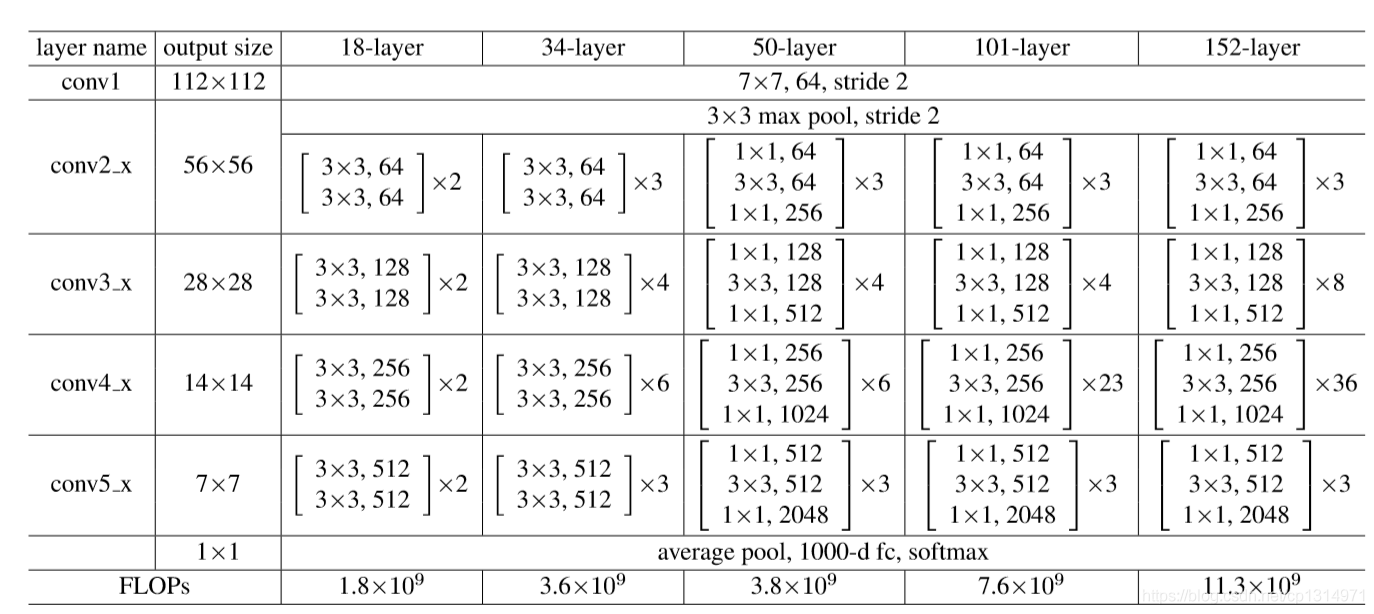

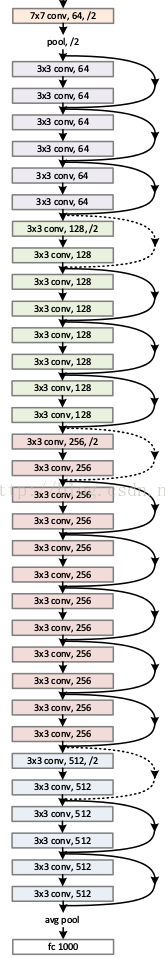

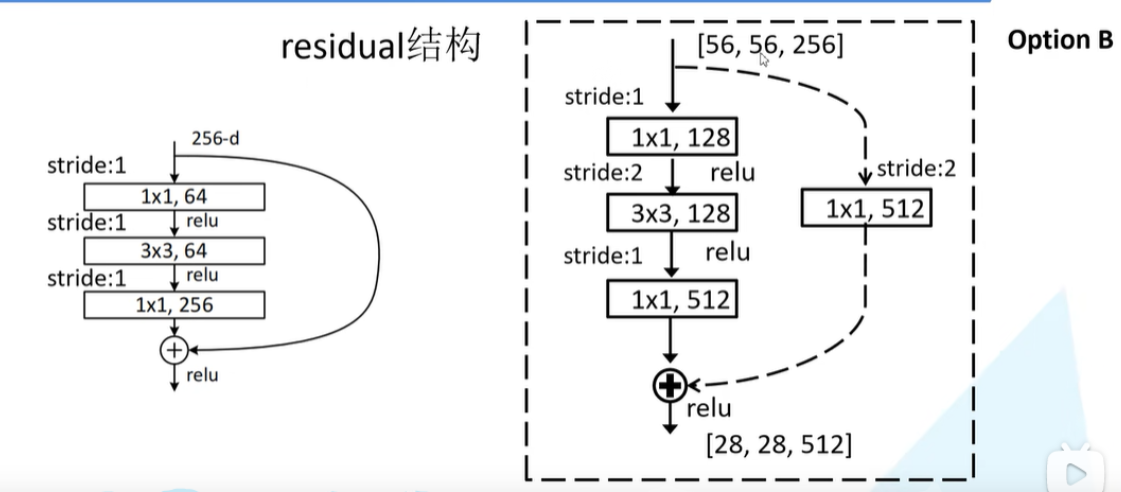

### 3.4 模型结构解析（restnet50）
- 1、conv1,stride=2,kernel_size=7,out_chnnels=64
- 2、conv2_x
    - 2.1、 max_pool:kernel_size=3, stride=2
    - 2.2、 conv_01:stride=1,kernel_size=1,out_chnnels=64
    - 2.3、 conv_02:stride=2,kernel_size=3,out_chnnels=64
    - 2.4、 conv_03:stride=1,kernel_size=1,out_chnnels=256
    - 2.5、 layers（conv_01+conv_02+conv_03）*3
- 3、conv3_x
    - 3.1、conv_01:stride=1,kernel_size=1,out_chnnels=128
    - 3.2、conv_02:stride=2,kernel_size=3,out_chnnels=128
    - 3.3、conv_03:stride=1,kernel_size=1,out_chnnels=512
    - 3.4、residual:stride=2,kernel_size=1,out_chnnels=512
    - 3.5、layers（conv_01+conv_02+conv_03）*4
- 4、conv4_x
    - 4.1、conv_01:stride=1,kernel_size=1,out_chnnels=256
    - 4.2、conv_02:stride=2,kernel_size=3,out_chnnels=256
    - 4.3、conv_03:stride=1,kernel_size=1,out_chnnels=1024
    - 4.4、residual:stride=2,kernel_size=1,out_chnnels=1024
    - 4.5、layers（conv_01+conv_02+conv_03）*6
- 5、conv5_x
    - 5.1、conv_01:stride=1,kernel_size=1,out_chnnels=512
    - 5.2、conv_02:stride=2,kernel_size=3,out_chnnels=512
    - 5.3、conv_03:stride=1,kernel_size=1,out_chnnels=2048
    - 5.4、residual:stride=2,kernel_size=1,out_chnnels=2048
    - 5.5、layers（conv_01+conv_02+conv_03）*3
- 6、fc
    - 6.1、AdaptiveAvgPool2d:output=（1,1）
    - 6.2、flatten：(x, 1)
    - 6.3、fc:linear(512 * 4，num_class)

In [27]:
import torch.nn as nn
import torch

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(Block, self).__init__()
        out_channel_01, out_channel_02, out_channel_03 = out_channels
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channel_01, kernel_size=1, stride=1,bias=False),
            nn.BatchNorm2d(out_channel_01),
            nn.ReLU(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel_01, out_channel_02, kernel_size=3, stride=stride, padding=1,  bias=False),
            nn.BatchNorm2d(out_channel_02),
            nn.ReLU(inplace=True)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channel_02, out_channel_03, kernel_size=1, stride=1,  bias=False),
            nn.BatchNorm2d(out_channel_03),
            )
        if downsample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channel_03, kernel_size=1, stride=stride,  bias=False),
                nn.BatchNorm2d(out_channel_03)
            )
            
    def forward(self,x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.downsample:
            x_shortcut = self.shortcut(x_shortcut)
        x = x + x_shortcut
        x = self.relu(x)
        return x
  


In [30]:
class Resnet50(nn.Module):

    def __init__(self):
        super(Resnet50,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        Layers = [3, 4, 6, 3]
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self._make_layer(64, (64, 64, 256), Layers[0],1)
        self.conv3 = self._make_layer(256, (128, 128, 512), Layers[1], 2)
        self.conv4 = self._make_layer(512, (256, 256, 1024), Layers[2], 2)
        self.conv5 = self._make_layer(1024, (512, 512, 2048), Layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(2048, 1000)
            )
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        block_1 = Block(in_channels, out_channels, stride=stride, downsample=True)
        layers.append(block_1)
        for i in range(1, blocks):
            layers.append(Block(out_channels[2], out_channels, stride=1, downsample=False))

        return nn.Sequential(*layers)


In [35]:
#打印网络结构
net = Resnet50()
x = torch.rand((10, 3, 224, 224))
for name,layer in net.named_children():
    if name != "fc":
        x = layer(x)
        print(name, 'output shaoe:', x.shape)
    else:
        x = x.view(x.size(0), -1)
        x = layer(x)
        print(name, 'output shaoe:', x.shape)


conv1 output shaoe: torch.Size([10, 64, 112, 112])
maxpool output shaoe: torch.Size([10, 64, 56, 56])
conv2 output shaoe: torch.Size([10, 256, 56, 56])
conv3 output shaoe: torch.Size([10, 512, 28, 28])
conv4 output shaoe: torch.Size([10, 1024, 14, 14])
conv5 output shaoe: torch.Size([10, 2048, 7, 7])
avgpool output shaoe: torch.Size([10, 2048, 1, 1])
fc output shaoe: torch.Size([10, 1000])


In [41]:
#torchinfo 可视化网络结构
from torchinfo import summary
net = Resnet50()

summary(net,((10, 3, 224, 224))) 

D:\Users\xulele\Anaconda3\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
D:\Users\xulele\Anaconda3\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Resnet50                                 [10, 1000]                --
├─Sequential: 1-1                        [10, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [10, 64, 112, 112]        9,472
│    └─BatchNorm2d: 2-2                  [10, 64, 112, 112]        128
│    └─ReLU: 2-3                         [10, 64, 112, 112]        --
├─MaxPool2d: 1-2                         [10, 64, 56, 56]          --
├─Sequential: 1-3                        [10, 256, 56, 56]         --
│    └─Block: 2-4                        [10, 256, 56, 56]         --
│    │    └─Sequential: 3-1              [10, 64, 56, 56]          4,224
│    │    └─Sequential: 3-2              [10, 64, 56, 56]          36,992
│    │    └─Sequential: 3-3              [10, 256, 56, 56]         16,896
│    │    └─Sequential: 3-4              [10, 256, 56, 56]         16,896
│    │    └─ReLU: 3-5                    [10, 256, 56, 56]        

In [47]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision
import os 
import numpy as np 
import torch

In [44]:
#超参数定义
# 批次的大小
batch_size = 16 #可选32、64、128
# 优化器的学习率
lr = 1e-4
#运行epoch
max_epochs = 2
# 方案一：指定GPU的方式
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # 指明调用的GPU为0,1号

# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 指明调用的GPU为1号

# 数据读取
#cifar10数据集为例给出构建Dataset类的方式
from torchvision import datasets

#“data_transform”可以对图像进行一定的变换，如翻转、裁剪、归一化等操作，可自己定义
data_transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                   ])


train_cifar_dataset = datasets.CIFAR10('cifar10',train=True, download=False,transform=data_transform)
test_cifar_dataset = datasets.CIFAR10('cifar10',train=False, download=False,transform=data_transform)

#构建好Dataset后，就可以使用DataLoader来按批次读入数据了

train_loader = torch.utils.data.DataLoader(train_cifar_dataset, 
                                           batch_size=batch_size, num_workers=4, 
                                           shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_cifar_dataset, 
                                         batch_size=batch_size, num_workers=4, 
                                         shuffle=False)

In [45]:
# from tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs')

In [48]:
#训练&验证
writer = SummaryWriter('./runs')
 # Set fixed random number seed
torch.manual_seed(42)
# 定义损失函数和优化器
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
My_model = Resnet50()
My_model = My_model.to(device)
# 交叉熵
criterion = torch.nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(My_model.parameters(), lr=lr)
epoch = max_epochs

total_step = len(train_loader)
train_all_loss = []
test_all_loss = []
for i in range(epoch):
    My_model.train()
    train_total_loss = 0
    train_total_num = 0
    train_total_correct = 0

    for iter, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Write the network graph at epoch 0, batch 0
        if epoch == 0 and iter == 0:
            writer.add_graph(My_model, input_to_model=(images,labels)[0], verbose=True)

        # Write an image at every batch 0
        if iter == 0:
            writer.add_image("Example input", images[0], global_step=epoch)
        
        outputs = My_model(images)
        loss = criterion(outputs,labels)
        train_total_correct += (outputs.argmax(1) == labels).sum().item()
        #backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_total_num += labels.shape[0]
        train_total_loss += loss.item()
        
        # Print statistics
        writer.add_scalar("Loss/Minibatches", train_total_loss, train_total_num)
        
        print("Epoch [{}/{}], Iter [{}/{}], train_loss:{:4f}".format(i+1,epoch,iter+1,total_step,loss.item()/labels.shape[0]))
    
    # Write loss for epoch
    writer.add_scalar("Loss/Epochs", train_total_loss, epoch)
    
    My_model.eval()
    test_total_loss = 0
    test_total_correct = 0
    test_total_num = 0
    for iter,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = My_model(images)
        loss = criterion(outputs,labels)
        test_total_correct += (outputs.argmax(1) == labels).sum().item()
        test_total_loss += loss.item()
        test_total_num += labels.shape[0]
    print("Epoch [{}/{}], train_loss:{:.4f}, train_acc:{:.4f}%, test_loss:{:.4f}, test_acc:{:.4f}%".format(
        i+1, epoch, train_total_loss / train_total_num, train_total_correct / train_total_num * 100, test_total_loss / test_total_num, test_total_correct / test_total_num * 100
    
    ))
    train_all_loss.append(np.round(train_total_loss / train_total_num,4))
    test_all_loss.append(np.round(test_total_loss / test_total_num,4))


Epoch [1/2], Iter [1/3125], train_loss:0.430043
Epoch [1/2], Iter [2/3125], train_loss:0.399217
Epoch [1/2], Iter [3/3125], train_loss:0.391730
Epoch [1/2], Iter [4/3125], train_loss:0.381970
Epoch [1/2], Iter [5/3125], train_loss:0.337084
Epoch [1/2], Iter [6/3125], train_loss:0.322986
Epoch [1/2], Iter [7/3125], train_loss:0.328911
Epoch [1/2], Iter [8/3125], train_loss:0.287385
Epoch [1/2], Iter [9/3125], train_loss:0.289794
Epoch [1/2], Iter [10/3125], train_loss:0.247583
Epoch [1/2], Iter [11/3125], train_loss:0.239406
Epoch [1/2], Iter [12/3125], train_loss:0.252444
Epoch [1/2], Iter [13/3125], train_loss:0.204779
Epoch [1/2], Iter [14/3125], train_loss:0.197130
Epoch [1/2], Iter [15/3125], train_loss:0.198398
Epoch [1/2], Iter [16/3125], train_loss:0.234318
Epoch [1/2], Iter [17/3125], train_loss:0.175272
Epoch [1/2], Iter [18/3125], train_loss:0.175399
Epoch [1/2], Iter [19/3125], train_loss:0.166614
Epoch [1/2], Iter [20/3125], train_loss:0.193967
Epoch [1/2], Iter [21/3125], 

Epoch [1/2], Iter [168/3125], train_loss:0.141326
Epoch [1/2], Iter [169/3125], train_loss:0.165799
Epoch [1/2], Iter [170/3125], train_loss:0.174329
Epoch [1/2], Iter [171/3125], train_loss:0.138570
Epoch [1/2], Iter [172/3125], train_loss:0.117236
Epoch [1/2], Iter [173/3125], train_loss:0.116505
Epoch [1/2], Iter [174/3125], train_loss:0.169864
Epoch [1/2], Iter [175/3125], train_loss:0.180966
Epoch [1/2], Iter [176/3125], train_loss:0.157741
Epoch [1/2], Iter [177/3125], train_loss:0.158464
Epoch [1/2], Iter [178/3125], train_loss:0.169416
Epoch [1/2], Iter [179/3125], train_loss:0.135209
Epoch [1/2], Iter [180/3125], train_loss:0.149782
Epoch [1/2], Iter [181/3125], train_loss:0.145131
Epoch [1/2], Iter [182/3125], train_loss:0.163330
Epoch [1/2], Iter [183/3125], train_loss:0.148288
Epoch [1/2], Iter [184/3125], train_loss:0.162434
Epoch [1/2], Iter [185/3125], train_loss:0.138171
Epoch [1/2], Iter [186/3125], train_loss:0.174453
Epoch [1/2], Iter [187/3125], train_loss:0.152246


Epoch [1/2], Iter [332/3125], train_loss:0.139802
Epoch [1/2], Iter [333/3125], train_loss:0.169329
Epoch [1/2], Iter [334/3125], train_loss:0.145734
Epoch [1/2], Iter [335/3125], train_loss:0.184645
Epoch [1/2], Iter [336/3125], train_loss:0.138695
Epoch [1/2], Iter [337/3125], train_loss:0.121887
Epoch [1/2], Iter [338/3125], train_loss:0.131833
Epoch [1/2], Iter [339/3125], train_loss:0.154317
Epoch [1/2], Iter [340/3125], train_loss:0.131791
Epoch [1/2], Iter [341/3125], train_loss:0.111341
Epoch [1/2], Iter [342/3125], train_loss:0.123395
Epoch [1/2], Iter [343/3125], train_loss:0.161068
Epoch [1/2], Iter [344/3125], train_loss:0.138011
Epoch [1/2], Iter [345/3125], train_loss:0.172757
Epoch [1/2], Iter [346/3125], train_loss:0.141580
Epoch [1/2], Iter [347/3125], train_loss:0.144634
Epoch [1/2], Iter [348/3125], train_loss:0.133607
Epoch [1/2], Iter [349/3125], train_loss:0.151957
Epoch [1/2], Iter [350/3125], train_loss:0.153514
Epoch [1/2], Iter [351/3125], train_loss:0.132827


Epoch [1/2], Iter [496/3125], train_loss:0.146182
Epoch [1/2], Iter [497/3125], train_loss:0.145437
Epoch [1/2], Iter [498/3125], train_loss:0.125500
Epoch [1/2], Iter [499/3125], train_loss:0.115408
Epoch [1/2], Iter [500/3125], train_loss:0.158740
Epoch [1/2], Iter [501/3125], train_loss:0.138249
Epoch [1/2], Iter [502/3125], train_loss:0.126816
Epoch [1/2], Iter [503/3125], train_loss:0.147844
Epoch [1/2], Iter [504/3125], train_loss:0.128878
Epoch [1/2], Iter [505/3125], train_loss:0.114013
Epoch [1/2], Iter [506/3125], train_loss:0.160102
Epoch [1/2], Iter [507/3125], train_loss:0.151201
Epoch [1/2], Iter [508/3125], train_loss:0.149264
Epoch [1/2], Iter [509/3125], train_loss:0.159143
Epoch [1/2], Iter [510/3125], train_loss:0.142965
Epoch [1/2], Iter [511/3125], train_loss:0.138246
Epoch [1/2], Iter [512/3125], train_loss:0.124573
Epoch [1/2], Iter [513/3125], train_loss:0.148881
Epoch [1/2], Iter [514/3125], train_loss:0.149671
Epoch [1/2], Iter [515/3125], train_loss:0.140685


Epoch [1/2], Iter [660/3125], train_loss:0.103687
Epoch [1/2], Iter [661/3125], train_loss:0.125754
Epoch [1/2], Iter [662/3125], train_loss:0.132972
Epoch [1/2], Iter [663/3125], train_loss:0.153800
Epoch [1/2], Iter [664/3125], train_loss:0.110952
Epoch [1/2], Iter [665/3125], train_loss:0.120236
Epoch [1/2], Iter [666/3125], train_loss:0.115589
Epoch [1/2], Iter [667/3125], train_loss:0.132908
Epoch [1/2], Iter [668/3125], train_loss:0.159913
Epoch [1/2], Iter [669/3125], train_loss:0.131979
Epoch [1/2], Iter [670/3125], train_loss:0.136179
Epoch [1/2], Iter [671/3125], train_loss:0.131732
Epoch [1/2], Iter [672/3125], train_loss:0.106427
Epoch [1/2], Iter [673/3125], train_loss:0.094495
Epoch [1/2], Iter [674/3125], train_loss:0.139270
Epoch [1/2], Iter [675/3125], train_loss:0.148814
Epoch [1/2], Iter [676/3125], train_loss:0.121234
Epoch [1/2], Iter [677/3125], train_loss:0.135534
Epoch [1/2], Iter [678/3125], train_loss:0.163135
Epoch [1/2], Iter [679/3125], train_loss:0.143060


Epoch [1/2], Iter [824/3125], train_loss:0.126279
Epoch [1/2], Iter [825/3125], train_loss:0.122051
Epoch [1/2], Iter [826/3125], train_loss:0.101408
Epoch [1/2], Iter [827/3125], train_loss:0.133676
Epoch [1/2], Iter [828/3125], train_loss:0.114889
Epoch [1/2], Iter [829/3125], train_loss:0.154637
Epoch [1/2], Iter [830/3125], train_loss:0.110613
Epoch [1/2], Iter [831/3125], train_loss:0.107352
Epoch [1/2], Iter [832/3125], train_loss:0.113590
Epoch [1/2], Iter [833/3125], train_loss:0.127768
Epoch [1/2], Iter [834/3125], train_loss:0.158357
Epoch [1/2], Iter [835/3125], train_loss:0.156968
Epoch [1/2], Iter [836/3125], train_loss:0.139370
Epoch [1/2], Iter [837/3125], train_loss:0.160966
Epoch [1/2], Iter [838/3125], train_loss:0.125671
Epoch [1/2], Iter [839/3125], train_loss:0.130724
Epoch [1/2], Iter [840/3125], train_loss:0.148446
Epoch [1/2], Iter [841/3125], train_loss:0.125982
Epoch [1/2], Iter [842/3125], train_loss:0.139492
Epoch [1/2], Iter [843/3125], train_loss:0.116199


Epoch [1/2], Iter [988/3125], train_loss:0.113887
Epoch [1/2], Iter [989/3125], train_loss:0.106621
Epoch [1/2], Iter [990/3125], train_loss:0.153951
Epoch [1/2], Iter [991/3125], train_loss:0.136528
Epoch [1/2], Iter [992/3125], train_loss:0.104794
Epoch [1/2], Iter [993/3125], train_loss:0.132386
Epoch [1/2], Iter [994/3125], train_loss:0.110921
Epoch [1/2], Iter [995/3125], train_loss:0.143581
Epoch [1/2], Iter [996/3125], train_loss:0.112366
Epoch [1/2], Iter [997/3125], train_loss:0.150791
Epoch [1/2], Iter [998/3125], train_loss:0.114965
Epoch [1/2], Iter [999/3125], train_loss:0.144281
Epoch [1/2], Iter [1000/3125], train_loss:0.097253
Epoch [1/2], Iter [1001/3125], train_loss:0.107015
Epoch [1/2], Iter [1002/3125], train_loss:0.124313
Epoch [1/2], Iter [1003/3125], train_loss:0.108577
Epoch [1/2], Iter [1004/3125], train_loss:0.134294
Epoch [1/2], Iter [1005/3125], train_loss:0.129103
Epoch [1/2], Iter [1006/3125], train_loss:0.127533
Epoch [1/2], Iter [1007/3125], train_loss:0

Epoch [1/2], Iter [1149/3125], train_loss:0.100778
Epoch [1/2], Iter [1150/3125], train_loss:0.121607
Epoch [1/2], Iter [1151/3125], train_loss:0.101407
Epoch [1/2], Iter [1152/3125], train_loss:0.135673
Epoch [1/2], Iter [1153/3125], train_loss:0.126425
Epoch [1/2], Iter [1154/3125], train_loss:0.093462
Epoch [1/2], Iter [1155/3125], train_loss:0.126472
Epoch [1/2], Iter [1156/3125], train_loss:0.130557
Epoch [1/2], Iter [1157/3125], train_loss:0.128323
Epoch [1/2], Iter [1158/3125], train_loss:0.130056
Epoch [1/2], Iter [1159/3125], train_loss:0.122581
Epoch [1/2], Iter [1160/3125], train_loss:0.086433
Epoch [1/2], Iter [1161/3125], train_loss:0.107591
Epoch [1/2], Iter [1162/3125], train_loss:0.149391
Epoch [1/2], Iter [1163/3125], train_loss:0.119678
Epoch [1/2], Iter [1164/3125], train_loss:0.108670
Epoch [1/2], Iter [1165/3125], train_loss:0.141502
Epoch [1/2], Iter [1166/3125], train_loss:0.114156
Epoch [1/2], Iter [1167/3125], train_loss:0.104277
Epoch [1/2], Iter [1168/3125], 

Epoch [1/2], Iter [1310/3125], train_loss:0.109602
Epoch [1/2], Iter [1311/3125], train_loss:0.092256
Epoch [1/2], Iter [1312/3125], train_loss:0.089961
Epoch [1/2], Iter [1313/3125], train_loss:0.138478
Epoch [1/2], Iter [1314/3125], train_loss:0.130750
Epoch [1/2], Iter [1315/3125], train_loss:0.098626
Epoch [1/2], Iter [1316/3125], train_loss:0.130637
Epoch [1/2], Iter [1317/3125], train_loss:0.113032
Epoch [1/2], Iter [1318/3125], train_loss:0.141212
Epoch [1/2], Iter [1319/3125], train_loss:0.159202
Epoch [1/2], Iter [1320/3125], train_loss:0.104703
Epoch [1/2], Iter [1321/3125], train_loss:0.130061
Epoch [1/2], Iter [1322/3125], train_loss:0.098450
Epoch [1/2], Iter [1323/3125], train_loss:0.118011
Epoch [1/2], Iter [1324/3125], train_loss:0.119083
Epoch [1/2], Iter [1325/3125], train_loss:0.122753
Epoch [1/2], Iter [1326/3125], train_loss:0.110272
Epoch [1/2], Iter [1327/3125], train_loss:0.124699
Epoch [1/2], Iter [1328/3125], train_loss:0.125460
Epoch [1/2], Iter [1329/3125], 

Epoch [1/2], Iter [1471/3125], train_loss:0.098426
Epoch [1/2], Iter [1472/3125], train_loss:0.143860
Epoch [1/2], Iter [1473/3125], train_loss:0.109508
Epoch [1/2], Iter [1474/3125], train_loss:0.099417
Epoch [1/2], Iter [1475/3125], train_loss:0.137157
Epoch [1/2], Iter [1476/3125], train_loss:0.129953
Epoch [1/2], Iter [1477/3125], train_loss:0.112809
Epoch [1/2], Iter [1478/3125], train_loss:0.113120
Epoch [1/2], Iter [1479/3125], train_loss:0.090743
Epoch [1/2], Iter [1480/3125], train_loss:0.129271
Epoch [1/2], Iter [1481/3125], train_loss:0.137313
Epoch [1/2], Iter [1482/3125], train_loss:0.108650
Epoch [1/2], Iter [1483/3125], train_loss:0.137887
Epoch [1/2], Iter [1484/3125], train_loss:0.117343
Epoch [1/2], Iter [1485/3125], train_loss:0.114352
Epoch [1/2], Iter [1486/3125], train_loss:0.101056
Epoch [1/2], Iter [1487/3125], train_loss:0.120009
Epoch [1/2], Iter [1488/3125], train_loss:0.122330
Epoch [1/2], Iter [1489/3125], train_loss:0.117299
Epoch [1/2], Iter [1490/3125], 

Epoch [1/2], Iter [1632/3125], train_loss:0.101524
Epoch [1/2], Iter [1633/3125], train_loss:0.117303
Epoch [1/2], Iter [1634/3125], train_loss:0.136640
Epoch [1/2], Iter [1635/3125], train_loss:0.104045
Epoch [1/2], Iter [1636/3125], train_loss:0.098606
Epoch [1/2], Iter [1637/3125], train_loss:0.109633
Epoch [1/2], Iter [1638/3125], train_loss:0.120075
Epoch [1/2], Iter [1639/3125], train_loss:0.140995
Epoch [1/2], Iter [1640/3125], train_loss:0.105396
Epoch [1/2], Iter [1641/3125], train_loss:0.114681
Epoch [1/2], Iter [1642/3125], train_loss:0.093426
Epoch [1/2], Iter [1643/3125], train_loss:0.108103
Epoch [1/2], Iter [1644/3125], train_loss:0.131016
Epoch [1/2], Iter [1645/3125], train_loss:0.133334
Epoch [1/2], Iter [1646/3125], train_loss:0.076322
Epoch [1/2], Iter [1647/3125], train_loss:0.104391
Epoch [1/2], Iter [1648/3125], train_loss:0.133650
Epoch [1/2], Iter [1649/3125], train_loss:0.117201
Epoch [1/2], Iter [1650/3125], train_loss:0.095546
Epoch [1/2], Iter [1651/3125], 

Epoch [1/2], Iter [1793/3125], train_loss:0.088301
Epoch [1/2], Iter [1794/3125], train_loss:0.116527
Epoch [1/2], Iter [1795/3125], train_loss:0.089206
Epoch [1/2], Iter [1796/3125], train_loss:0.108409
Epoch [1/2], Iter [1797/3125], train_loss:0.095537
Epoch [1/2], Iter [1798/3125], train_loss:0.100983
Epoch [1/2], Iter [1799/3125], train_loss:0.112310
Epoch [1/2], Iter [1800/3125], train_loss:0.105625
Epoch [1/2], Iter [1801/3125], train_loss:0.106045
Epoch [1/2], Iter [1802/3125], train_loss:0.118067
Epoch [1/2], Iter [1803/3125], train_loss:0.103582
Epoch [1/2], Iter [1804/3125], train_loss:0.083729
Epoch [1/2], Iter [1805/3125], train_loss:0.133233
Epoch [1/2], Iter [1806/3125], train_loss:0.100614
Epoch [1/2], Iter [1807/3125], train_loss:0.102098
Epoch [1/2], Iter [1808/3125], train_loss:0.094543
Epoch [1/2], Iter [1809/3125], train_loss:0.120425
Epoch [1/2], Iter [1810/3125], train_loss:0.121749
Epoch [1/2], Iter [1811/3125], train_loss:0.094081
Epoch [1/2], Iter [1812/3125], 

Epoch [1/2], Iter [1954/3125], train_loss:0.105019
Epoch [1/2], Iter [1955/3125], train_loss:0.141218
Epoch [1/2], Iter [1956/3125], train_loss:0.086414
Epoch [1/2], Iter [1957/3125], train_loss:0.122000
Epoch [1/2], Iter [1958/3125], train_loss:0.108958
Epoch [1/2], Iter [1959/3125], train_loss:0.109269
Epoch [1/2], Iter [1960/3125], train_loss:0.106017
Epoch [1/2], Iter [1961/3125], train_loss:0.107679
Epoch [1/2], Iter [1962/3125], train_loss:0.114157
Epoch [1/2], Iter [1963/3125], train_loss:0.088606
Epoch [1/2], Iter [1964/3125], train_loss:0.104400
Epoch [1/2], Iter [1965/3125], train_loss:0.084936
Epoch [1/2], Iter [1966/3125], train_loss:0.112303
Epoch [1/2], Iter [1967/3125], train_loss:0.101845
Epoch [1/2], Iter [1968/3125], train_loss:0.118825
Epoch [1/2], Iter [1969/3125], train_loss:0.121779
Epoch [1/2], Iter [1970/3125], train_loss:0.074884
Epoch [1/2], Iter [1971/3125], train_loss:0.117793
Epoch [1/2], Iter [1972/3125], train_loss:0.090739
Epoch [1/2], Iter [1973/3125], 

Epoch [1/2], Iter [2115/3125], train_loss:0.083379
Epoch [1/2], Iter [2116/3125], train_loss:0.090572
Epoch [1/2], Iter [2117/3125], train_loss:0.096028
Epoch [1/2], Iter [2118/3125], train_loss:0.096893
Epoch [1/2], Iter [2119/3125], train_loss:0.114034
Epoch [1/2], Iter [2120/3125], train_loss:0.124006
Epoch [1/2], Iter [2121/3125], train_loss:0.125319
Epoch [1/2], Iter [2122/3125], train_loss:0.093370
Epoch [1/2], Iter [2123/3125], train_loss:0.094484
Epoch [1/2], Iter [2124/3125], train_loss:0.117593
Epoch [1/2], Iter [2125/3125], train_loss:0.088641
Epoch [1/2], Iter [2126/3125], train_loss:0.100637
Epoch [1/2], Iter [2127/3125], train_loss:0.125044
Epoch [1/2], Iter [2128/3125], train_loss:0.102803
Epoch [1/2], Iter [2129/3125], train_loss:0.100716
Epoch [1/2], Iter [2130/3125], train_loss:0.100396
Epoch [1/2], Iter [2131/3125], train_loss:0.110038
Epoch [1/2], Iter [2132/3125], train_loss:0.085658
Epoch [1/2], Iter [2133/3125], train_loss:0.111865
Epoch [1/2], Iter [2134/3125], 

Epoch [1/2], Iter [2276/3125], train_loss:0.094937
Epoch [1/2], Iter [2277/3125], train_loss:0.119222
Epoch [1/2], Iter [2278/3125], train_loss:0.097568
Epoch [1/2], Iter [2279/3125], train_loss:0.102922
Epoch [1/2], Iter [2280/3125], train_loss:0.111276
Epoch [1/2], Iter [2281/3125], train_loss:0.089530
Epoch [1/2], Iter [2282/3125], train_loss:0.118905
Epoch [1/2], Iter [2283/3125], train_loss:0.086163
Epoch [1/2], Iter [2284/3125], train_loss:0.110971
Epoch [1/2], Iter [2285/3125], train_loss:0.112254
Epoch [1/2], Iter [2286/3125], train_loss:0.092250
Epoch [1/2], Iter [2287/3125], train_loss:0.106539
Epoch [1/2], Iter [2288/3125], train_loss:0.098029
Epoch [1/2], Iter [2289/3125], train_loss:0.103773
Epoch [1/2], Iter [2290/3125], train_loss:0.129419
Epoch [1/2], Iter [2291/3125], train_loss:0.098723
Epoch [1/2], Iter [2292/3125], train_loss:0.108025
Epoch [1/2], Iter [2293/3125], train_loss:0.124437
Epoch [1/2], Iter [2294/3125], train_loss:0.077301
Epoch [1/2], Iter [2295/3125], 

Epoch [1/2], Iter [2437/3125], train_loss:0.095079
Epoch [1/2], Iter [2438/3125], train_loss:0.089631
Epoch [1/2], Iter [2439/3125], train_loss:0.095069
Epoch [1/2], Iter [2440/3125], train_loss:0.108419
Epoch [1/2], Iter [2441/3125], train_loss:0.112826
Epoch [1/2], Iter [2442/3125], train_loss:0.111640
Epoch [1/2], Iter [2443/3125], train_loss:0.113391
Epoch [1/2], Iter [2444/3125], train_loss:0.131918
Epoch [1/2], Iter [2445/3125], train_loss:0.076390
Epoch [1/2], Iter [2446/3125], train_loss:0.101470
Epoch [1/2], Iter [2447/3125], train_loss:0.085170
Epoch [1/2], Iter [2448/3125], train_loss:0.089206
Epoch [1/2], Iter [2449/3125], train_loss:0.099683
Epoch [1/2], Iter [2450/3125], train_loss:0.086865
Epoch [1/2], Iter [2451/3125], train_loss:0.128651
Epoch [1/2], Iter [2452/3125], train_loss:0.090884
Epoch [1/2], Iter [2453/3125], train_loss:0.106414
Epoch [1/2], Iter [2454/3125], train_loss:0.127482
Epoch [1/2], Iter [2455/3125], train_loss:0.076910
Epoch [1/2], Iter [2456/3125], 

Epoch [1/2], Iter [2598/3125], train_loss:0.085577
Epoch [1/2], Iter [2599/3125], train_loss:0.097302
Epoch [1/2], Iter [2600/3125], train_loss:0.088938
Epoch [1/2], Iter [2601/3125], train_loss:0.115304
Epoch [1/2], Iter [2602/3125], train_loss:0.133274
Epoch [1/2], Iter [2603/3125], train_loss:0.145121
Epoch [1/2], Iter [2604/3125], train_loss:0.084187
Epoch [1/2], Iter [2605/3125], train_loss:0.129197
Epoch [1/2], Iter [2606/3125], train_loss:0.093822
Epoch [1/2], Iter [2607/3125], train_loss:0.101598
Epoch [1/2], Iter [2608/3125], train_loss:0.140341
Epoch [1/2], Iter [2609/3125], train_loss:0.115032
Epoch [1/2], Iter [2610/3125], train_loss:0.120124
Epoch [1/2], Iter [2611/3125], train_loss:0.110905
Epoch [1/2], Iter [2612/3125], train_loss:0.089199
Epoch [1/2], Iter [2613/3125], train_loss:0.104073
Epoch [1/2], Iter [2614/3125], train_loss:0.100672
Epoch [1/2], Iter [2615/3125], train_loss:0.111184
Epoch [1/2], Iter [2616/3125], train_loss:0.109902
Epoch [1/2], Iter [2617/3125], 

Epoch [1/2], Iter [2759/3125], train_loss:0.089157
Epoch [1/2], Iter [2760/3125], train_loss:0.113698
Epoch [1/2], Iter [2761/3125], train_loss:0.091779
Epoch [1/2], Iter [2762/3125], train_loss:0.079673
Epoch [1/2], Iter [2763/3125], train_loss:0.103621
Epoch [1/2], Iter [2764/3125], train_loss:0.082735
Epoch [1/2], Iter [2765/3125], train_loss:0.105204
Epoch [1/2], Iter [2766/3125], train_loss:0.086259
Epoch [1/2], Iter [2767/3125], train_loss:0.123802
Epoch [1/2], Iter [2768/3125], train_loss:0.099351
Epoch [1/2], Iter [2769/3125], train_loss:0.109434
Epoch [1/2], Iter [2770/3125], train_loss:0.090484
Epoch [1/2], Iter [2771/3125], train_loss:0.121009
Epoch [1/2], Iter [2772/3125], train_loss:0.112087
Epoch [1/2], Iter [2773/3125], train_loss:0.107433
Epoch [1/2], Iter [2774/3125], train_loss:0.105113
Epoch [1/2], Iter [2775/3125], train_loss:0.118956
Epoch [1/2], Iter [2776/3125], train_loss:0.112925
Epoch [1/2], Iter [2777/3125], train_loss:0.100105
Epoch [1/2], Iter [2778/3125], 

Epoch [1/2], Iter [2920/3125], train_loss:0.134570
Epoch [1/2], Iter [2921/3125], train_loss:0.088210
Epoch [1/2], Iter [2922/3125], train_loss:0.088639
Epoch [1/2], Iter [2923/3125], train_loss:0.101916
Epoch [1/2], Iter [2924/3125], train_loss:0.121580
Epoch [1/2], Iter [2925/3125], train_loss:0.092680
Epoch [1/2], Iter [2926/3125], train_loss:0.092212
Epoch [1/2], Iter [2927/3125], train_loss:0.110600
Epoch [1/2], Iter [2928/3125], train_loss:0.076853
Epoch [1/2], Iter [2929/3125], train_loss:0.085440
Epoch [1/2], Iter [2930/3125], train_loss:0.103700
Epoch [1/2], Iter [2931/3125], train_loss:0.112204
Epoch [1/2], Iter [2932/3125], train_loss:0.100517
Epoch [1/2], Iter [2933/3125], train_loss:0.090385
Epoch [1/2], Iter [2934/3125], train_loss:0.100238
Epoch [1/2], Iter [2935/3125], train_loss:0.095390
Epoch [1/2], Iter [2936/3125], train_loss:0.102841
Epoch [1/2], Iter [2937/3125], train_loss:0.153473
Epoch [1/2], Iter [2938/3125], train_loss:0.150890
Epoch [1/2], Iter [2939/3125], 

Epoch [1/2], Iter [3081/3125], train_loss:0.111499
Epoch [1/2], Iter [3082/3125], train_loss:0.091926
Epoch [1/2], Iter [3083/3125], train_loss:0.126225
Epoch [1/2], Iter [3084/3125], train_loss:0.085915
Epoch [1/2], Iter [3085/3125], train_loss:0.086037
Epoch [1/2], Iter [3086/3125], train_loss:0.072105
Epoch [1/2], Iter [3087/3125], train_loss:0.124601
Epoch [1/2], Iter [3088/3125], train_loss:0.131993
Epoch [1/2], Iter [3089/3125], train_loss:0.113655
Epoch [1/2], Iter [3090/3125], train_loss:0.110477
Epoch [1/2], Iter [3091/3125], train_loss:0.083211
Epoch [1/2], Iter [3092/3125], train_loss:0.093807
Epoch [1/2], Iter [3093/3125], train_loss:0.104893
Epoch [1/2], Iter [3094/3125], train_loss:0.099689
Epoch [1/2], Iter [3095/3125], train_loss:0.104535
Epoch [1/2], Iter [3096/3125], train_loss:0.098604
Epoch [1/2], Iter [3097/3125], train_loss:0.099393
Epoch [1/2], Iter [3098/3125], train_loss:0.122256
Epoch [1/2], Iter [3099/3125], train_loss:0.119814
Epoch [1/2], Iter [3100/3125], 

Epoch [2/2], Iter [120/3125], train_loss:0.105514
Epoch [2/2], Iter [121/3125], train_loss:0.136283
Epoch [2/2], Iter [122/3125], train_loss:0.103037
Epoch [2/2], Iter [123/3125], train_loss:0.097136
Epoch [2/2], Iter [124/3125], train_loss:0.101025
Epoch [2/2], Iter [125/3125], train_loss:0.094171
Epoch [2/2], Iter [126/3125], train_loss:0.121665
Epoch [2/2], Iter [127/3125], train_loss:0.092011
Epoch [2/2], Iter [128/3125], train_loss:0.078880
Epoch [2/2], Iter [129/3125], train_loss:0.128020
Epoch [2/2], Iter [130/3125], train_loss:0.072524
Epoch [2/2], Iter [131/3125], train_loss:0.071616
Epoch [2/2], Iter [132/3125], train_loss:0.096712
Epoch [2/2], Iter [133/3125], train_loss:0.093573
Epoch [2/2], Iter [134/3125], train_loss:0.121898
Epoch [2/2], Iter [135/3125], train_loss:0.093081
Epoch [2/2], Iter [136/3125], train_loss:0.105385
Epoch [2/2], Iter [137/3125], train_loss:0.103334
Epoch [2/2], Iter [138/3125], train_loss:0.083012
Epoch [2/2], Iter [139/3125], train_loss:0.123903


Epoch [2/2], Iter [284/3125], train_loss:0.091778
Epoch [2/2], Iter [285/3125], train_loss:0.100697
Epoch [2/2], Iter [286/3125], train_loss:0.061429
Epoch [2/2], Iter [287/3125], train_loss:0.103810
Epoch [2/2], Iter [288/3125], train_loss:0.074329
Epoch [2/2], Iter [289/3125], train_loss:0.086135
Epoch [2/2], Iter [290/3125], train_loss:0.052865
Epoch [2/2], Iter [291/3125], train_loss:0.064886
Epoch [2/2], Iter [292/3125], train_loss:0.083900
Epoch [2/2], Iter [293/3125], train_loss:0.109142
Epoch [2/2], Iter [294/3125], train_loss:0.092724
Epoch [2/2], Iter [295/3125], train_loss:0.120955
Epoch [2/2], Iter [296/3125], train_loss:0.083090
Epoch [2/2], Iter [297/3125], train_loss:0.086837
Epoch [2/2], Iter [298/3125], train_loss:0.080210
Epoch [2/2], Iter [299/3125], train_loss:0.091169
Epoch [2/2], Iter [300/3125], train_loss:0.096427
Epoch [2/2], Iter [301/3125], train_loss:0.120840
Epoch [2/2], Iter [302/3125], train_loss:0.068802
Epoch [2/2], Iter [303/3125], train_loss:0.083719


Epoch [2/2], Iter [448/3125], train_loss:0.110809
Epoch [2/2], Iter [449/3125], train_loss:0.097352
Epoch [2/2], Iter [450/3125], train_loss:0.094873
Epoch [2/2], Iter [451/3125], train_loss:0.109798
Epoch [2/2], Iter [452/3125], train_loss:0.108717
Epoch [2/2], Iter [453/3125], train_loss:0.091716
Epoch [2/2], Iter [454/3125], train_loss:0.090690
Epoch [2/2], Iter [455/3125], train_loss:0.094762
Epoch [2/2], Iter [456/3125], train_loss:0.111473
Epoch [2/2], Iter [457/3125], train_loss:0.103065
Epoch [2/2], Iter [458/3125], train_loss:0.108422
Epoch [2/2], Iter [459/3125], train_loss:0.102061
Epoch [2/2], Iter [460/3125], train_loss:0.102083
Epoch [2/2], Iter [461/3125], train_loss:0.109224
Epoch [2/2], Iter [462/3125], train_loss:0.104043
Epoch [2/2], Iter [463/3125], train_loss:0.065878
Epoch [2/2], Iter [464/3125], train_loss:0.091389
Epoch [2/2], Iter [465/3125], train_loss:0.115812
Epoch [2/2], Iter [466/3125], train_loss:0.118369
Epoch [2/2], Iter [467/3125], train_loss:0.068617


Epoch [2/2], Iter [612/3125], train_loss:0.086869
Epoch [2/2], Iter [613/3125], train_loss:0.085953
Epoch [2/2], Iter [614/3125], train_loss:0.083555
Epoch [2/2], Iter [615/3125], train_loss:0.068392
Epoch [2/2], Iter [616/3125], train_loss:0.082908
Epoch [2/2], Iter [617/3125], train_loss:0.097139
Epoch [2/2], Iter [618/3125], train_loss:0.088849
Epoch [2/2], Iter [619/3125], train_loss:0.114269
Epoch [2/2], Iter [620/3125], train_loss:0.096929
Epoch [2/2], Iter [621/3125], train_loss:0.099542
Epoch [2/2], Iter [622/3125], train_loss:0.089321
Epoch [2/2], Iter [623/3125], train_loss:0.123321
Epoch [2/2], Iter [624/3125], train_loss:0.079554
Epoch [2/2], Iter [625/3125], train_loss:0.082541
Epoch [2/2], Iter [626/3125], train_loss:0.085805
Epoch [2/2], Iter [627/3125], train_loss:0.116099
Epoch [2/2], Iter [628/3125], train_loss:0.062045
Epoch [2/2], Iter [629/3125], train_loss:0.093665
Epoch [2/2], Iter [630/3125], train_loss:0.096117
Epoch [2/2], Iter [631/3125], train_loss:0.120881


Epoch [2/2], Iter [776/3125], train_loss:0.118939
Epoch [2/2], Iter [777/3125], train_loss:0.116502
Epoch [2/2], Iter [778/3125], train_loss:0.100367
Epoch [2/2], Iter [779/3125], train_loss:0.101167
Epoch [2/2], Iter [780/3125], train_loss:0.102839
Epoch [2/2], Iter [781/3125], train_loss:0.066892
Epoch [2/2], Iter [782/3125], train_loss:0.087467
Epoch [2/2], Iter [783/3125], train_loss:0.101108
Epoch [2/2], Iter [784/3125], train_loss:0.096700
Epoch [2/2], Iter [785/3125], train_loss:0.087809
Epoch [2/2], Iter [786/3125], train_loss:0.095772
Epoch [2/2], Iter [787/3125], train_loss:0.064771
Epoch [2/2], Iter [788/3125], train_loss:0.103117
Epoch [2/2], Iter [789/3125], train_loss:0.074872
Epoch [2/2], Iter [790/3125], train_loss:0.136279
Epoch [2/2], Iter [791/3125], train_loss:0.069266
Epoch [2/2], Iter [792/3125], train_loss:0.076346
Epoch [2/2], Iter [793/3125], train_loss:0.077704
Epoch [2/2], Iter [794/3125], train_loss:0.099309
Epoch [2/2], Iter [795/3125], train_loss:0.093810


Epoch [2/2], Iter [940/3125], train_loss:0.101029
Epoch [2/2], Iter [941/3125], train_loss:0.108483
Epoch [2/2], Iter [942/3125], train_loss:0.100051
Epoch [2/2], Iter [943/3125], train_loss:0.106296
Epoch [2/2], Iter [944/3125], train_loss:0.072279
Epoch [2/2], Iter [945/3125], train_loss:0.143448
Epoch [2/2], Iter [946/3125], train_loss:0.084587
Epoch [2/2], Iter [947/3125], train_loss:0.073256
Epoch [2/2], Iter [948/3125], train_loss:0.083115
Epoch [2/2], Iter [949/3125], train_loss:0.076965
Epoch [2/2], Iter [950/3125], train_loss:0.083379
Epoch [2/2], Iter [951/3125], train_loss:0.078656
Epoch [2/2], Iter [952/3125], train_loss:0.080206
Epoch [2/2], Iter [953/3125], train_loss:0.088033
Epoch [2/2], Iter [954/3125], train_loss:0.094281
Epoch [2/2], Iter [955/3125], train_loss:0.109771
Epoch [2/2], Iter [956/3125], train_loss:0.098340
Epoch [2/2], Iter [957/3125], train_loss:0.103174
Epoch [2/2], Iter [958/3125], train_loss:0.070675
Epoch [2/2], Iter [959/3125], train_loss:0.092117


Epoch [2/2], Iter [1102/3125], train_loss:0.088965
Epoch [2/2], Iter [1103/3125], train_loss:0.091780
Epoch [2/2], Iter [1104/3125], train_loss:0.100870
Epoch [2/2], Iter [1105/3125], train_loss:0.124838
Epoch [2/2], Iter [1106/3125], train_loss:0.077801
Epoch [2/2], Iter [1107/3125], train_loss:0.078026
Epoch [2/2], Iter [1108/3125], train_loss:0.081214
Epoch [2/2], Iter [1109/3125], train_loss:0.158262
Epoch [2/2], Iter [1110/3125], train_loss:0.106917
Epoch [2/2], Iter [1111/3125], train_loss:0.079547
Epoch [2/2], Iter [1112/3125], train_loss:0.101979
Epoch [2/2], Iter [1113/3125], train_loss:0.113243
Epoch [2/2], Iter [1114/3125], train_loss:0.108204
Epoch [2/2], Iter [1115/3125], train_loss:0.103011
Epoch [2/2], Iter [1116/3125], train_loss:0.097713
Epoch [2/2], Iter [1117/3125], train_loss:0.113078
Epoch [2/2], Iter [1118/3125], train_loss:0.089141
Epoch [2/2], Iter [1119/3125], train_loss:0.089844
Epoch [2/2], Iter [1120/3125], train_loss:0.081608
Epoch [2/2], Iter [1121/3125], 

Epoch [2/2], Iter [1263/3125], train_loss:0.122619
Epoch [2/2], Iter [1264/3125], train_loss:0.115120
Epoch [2/2], Iter [1265/3125], train_loss:0.097016
Epoch [2/2], Iter [1266/3125], train_loss:0.088699
Epoch [2/2], Iter [1267/3125], train_loss:0.101548
Epoch [2/2], Iter [1268/3125], train_loss:0.069483
Epoch [2/2], Iter [1269/3125], train_loss:0.099193
Epoch [2/2], Iter [1270/3125], train_loss:0.098580
Epoch [2/2], Iter [1271/3125], train_loss:0.081832
Epoch [2/2], Iter [1272/3125], train_loss:0.090262
Epoch [2/2], Iter [1273/3125], train_loss:0.116728
Epoch [2/2], Iter [1274/3125], train_loss:0.084173
Epoch [2/2], Iter [1275/3125], train_loss:0.070421
Epoch [2/2], Iter [1276/3125], train_loss:0.138332
Epoch [2/2], Iter [1277/3125], train_loss:0.095311
Epoch [2/2], Iter [1278/3125], train_loss:0.094065
Epoch [2/2], Iter [1279/3125], train_loss:0.065093
Epoch [2/2], Iter [1280/3125], train_loss:0.109927
Epoch [2/2], Iter [1281/3125], train_loss:0.109715
Epoch [2/2], Iter [1282/3125], 

Epoch [2/2], Iter [1424/3125], train_loss:0.100455
Epoch [2/2], Iter [1425/3125], train_loss:0.096302
Epoch [2/2], Iter [1426/3125], train_loss:0.099798
Epoch [2/2], Iter [1427/3125], train_loss:0.095270
Epoch [2/2], Iter [1428/3125], train_loss:0.089735
Epoch [2/2], Iter [1429/3125], train_loss:0.086027
Epoch [2/2], Iter [1430/3125], train_loss:0.097187
Epoch [2/2], Iter [1431/3125], train_loss:0.082726
Epoch [2/2], Iter [1432/3125], train_loss:0.094490
Epoch [2/2], Iter [1433/3125], train_loss:0.069407
Epoch [2/2], Iter [1434/3125], train_loss:0.089940
Epoch [2/2], Iter [1435/3125], train_loss:0.108348
Epoch [2/2], Iter [1436/3125], train_loss:0.060262
Epoch [2/2], Iter [1437/3125], train_loss:0.106779
Epoch [2/2], Iter [1438/3125], train_loss:0.107624
Epoch [2/2], Iter [1439/3125], train_loss:0.125742
Epoch [2/2], Iter [1440/3125], train_loss:0.092230
Epoch [2/2], Iter [1441/3125], train_loss:0.080240
Epoch [2/2], Iter [1442/3125], train_loss:0.093263
Epoch [2/2], Iter [1443/3125], 

Epoch [2/2], Iter [1585/3125], train_loss:0.069987
Epoch [2/2], Iter [1586/3125], train_loss:0.089969
Epoch [2/2], Iter [1587/3125], train_loss:0.118200
Epoch [2/2], Iter [1588/3125], train_loss:0.086439
Epoch [2/2], Iter [1589/3125], train_loss:0.111907
Epoch [2/2], Iter [1590/3125], train_loss:0.105683
Epoch [2/2], Iter [1591/3125], train_loss:0.104853
Epoch [2/2], Iter [1592/3125], train_loss:0.061182
Epoch [2/2], Iter [1593/3125], train_loss:0.107764
Epoch [2/2], Iter [1594/3125], train_loss:0.129925
Epoch [2/2], Iter [1595/3125], train_loss:0.101261
Epoch [2/2], Iter [1596/3125], train_loss:0.102299
Epoch [2/2], Iter [1597/3125], train_loss:0.113133
Epoch [2/2], Iter [1598/3125], train_loss:0.090894
Epoch [2/2], Iter [1599/3125], train_loss:0.062855
Epoch [2/2], Iter [1600/3125], train_loss:0.088153
Epoch [2/2], Iter [1601/3125], train_loss:0.078138
Epoch [2/2], Iter [1602/3125], train_loss:0.102361
Epoch [2/2], Iter [1603/3125], train_loss:0.084010
Epoch [2/2], Iter [1604/3125], 

Epoch [2/2], Iter [1746/3125], train_loss:0.091254
Epoch [2/2], Iter [1747/3125], train_loss:0.093147
Epoch [2/2], Iter [1748/3125], train_loss:0.103437
Epoch [2/2], Iter [1749/3125], train_loss:0.105771
Epoch [2/2], Iter [1750/3125], train_loss:0.093988
Epoch [2/2], Iter [1751/3125], train_loss:0.077842
Epoch [2/2], Iter [1752/3125], train_loss:0.092619
Epoch [2/2], Iter [1753/3125], train_loss:0.077046
Epoch [2/2], Iter [1754/3125], train_loss:0.085107
Epoch [2/2], Iter [1755/3125], train_loss:0.091869
Epoch [2/2], Iter [1756/3125], train_loss:0.104868
Epoch [2/2], Iter [1757/3125], train_loss:0.081327
Epoch [2/2], Iter [1758/3125], train_loss:0.106563
Epoch [2/2], Iter [1759/3125], train_loss:0.109079
Epoch [2/2], Iter [1760/3125], train_loss:0.077260
Epoch [2/2], Iter [1761/3125], train_loss:0.089683
Epoch [2/2], Iter [1762/3125], train_loss:0.126763
Epoch [2/2], Iter [1763/3125], train_loss:0.109087
Epoch [2/2], Iter [1764/3125], train_loss:0.115221
Epoch [2/2], Iter [1765/3125], 

Epoch [2/2], Iter [1907/3125], train_loss:0.100264
Epoch [2/2], Iter [1908/3125], train_loss:0.097474
Epoch [2/2], Iter [1909/3125], train_loss:0.063589
Epoch [2/2], Iter [1910/3125], train_loss:0.079224
Epoch [2/2], Iter [1911/3125], train_loss:0.087697
Epoch [2/2], Iter [1912/3125], train_loss:0.107998
Epoch [2/2], Iter [1913/3125], train_loss:0.096968
Epoch [2/2], Iter [1914/3125], train_loss:0.111386
Epoch [2/2], Iter [1915/3125], train_loss:0.084712
Epoch [2/2], Iter [1916/3125], train_loss:0.075485
Epoch [2/2], Iter [1917/3125], train_loss:0.107463
Epoch [2/2], Iter [1918/3125], train_loss:0.076945
Epoch [2/2], Iter [1919/3125], train_loss:0.062623
Epoch [2/2], Iter [1920/3125], train_loss:0.111626
Epoch [2/2], Iter [1921/3125], train_loss:0.104793
Epoch [2/2], Iter [1922/3125], train_loss:0.116501
Epoch [2/2], Iter [1923/3125], train_loss:0.094834
Epoch [2/2], Iter [1924/3125], train_loss:0.080643
Epoch [2/2], Iter [1925/3125], train_loss:0.114903
Epoch [2/2], Iter [1926/3125], 

Epoch [2/2], Iter [2068/3125], train_loss:0.097060
Epoch [2/2], Iter [2069/3125], train_loss:0.099074
Epoch [2/2], Iter [2070/3125], train_loss:0.075420
Epoch [2/2], Iter [2071/3125], train_loss:0.092054
Epoch [2/2], Iter [2072/3125], train_loss:0.074084
Epoch [2/2], Iter [2073/3125], train_loss:0.093780
Epoch [2/2], Iter [2074/3125], train_loss:0.064100
Epoch [2/2], Iter [2075/3125], train_loss:0.073519
Epoch [2/2], Iter [2076/3125], train_loss:0.111293
Epoch [2/2], Iter [2077/3125], train_loss:0.091767
Epoch [2/2], Iter [2078/3125], train_loss:0.077094
Epoch [2/2], Iter [2079/3125], train_loss:0.093744
Epoch [2/2], Iter [2080/3125], train_loss:0.102374
Epoch [2/2], Iter [2081/3125], train_loss:0.086524
Epoch [2/2], Iter [2082/3125], train_loss:0.088591
Epoch [2/2], Iter [2083/3125], train_loss:0.118428
Epoch [2/2], Iter [2084/3125], train_loss:0.154954
Epoch [2/2], Iter [2085/3125], train_loss:0.062047
Epoch [2/2], Iter [2086/3125], train_loss:0.081366
Epoch [2/2], Iter [2087/3125], 

Epoch [2/2], Iter [2229/3125], train_loss:0.076998
Epoch [2/2], Iter [2230/3125], train_loss:0.099684
Epoch [2/2], Iter [2231/3125], train_loss:0.080119
Epoch [2/2], Iter [2232/3125], train_loss:0.102033
Epoch [2/2], Iter [2233/3125], train_loss:0.072623
Epoch [2/2], Iter [2234/3125], train_loss:0.080494
Epoch [2/2], Iter [2235/3125], train_loss:0.101878
Epoch [2/2], Iter [2236/3125], train_loss:0.098963
Epoch [2/2], Iter [2237/3125], train_loss:0.103091
Epoch [2/2], Iter [2238/3125], train_loss:0.090432
Epoch [2/2], Iter [2239/3125], train_loss:0.083601
Epoch [2/2], Iter [2240/3125], train_loss:0.076096
Epoch [2/2], Iter [2241/3125], train_loss:0.084545
Epoch [2/2], Iter [2242/3125], train_loss:0.091932
Epoch [2/2], Iter [2243/3125], train_loss:0.106137
Epoch [2/2], Iter [2244/3125], train_loss:0.160094
Epoch [2/2], Iter [2245/3125], train_loss:0.111792
Epoch [2/2], Iter [2246/3125], train_loss:0.095253
Epoch [2/2], Iter [2247/3125], train_loss:0.123218
Epoch [2/2], Iter [2248/3125], 

Epoch [2/2], Iter [2390/3125], train_loss:0.084817
Epoch [2/2], Iter [2391/3125], train_loss:0.094925
Epoch [2/2], Iter [2392/3125], train_loss:0.104477
Epoch [2/2], Iter [2393/3125], train_loss:0.078054
Epoch [2/2], Iter [2394/3125], train_loss:0.095577
Epoch [2/2], Iter [2395/3125], train_loss:0.148416
Epoch [2/2], Iter [2396/3125], train_loss:0.101446
Epoch [2/2], Iter [2397/3125], train_loss:0.122992
Epoch [2/2], Iter [2398/3125], train_loss:0.073000
Epoch [2/2], Iter [2399/3125], train_loss:0.091481
Epoch [2/2], Iter [2400/3125], train_loss:0.081014
Epoch [2/2], Iter [2401/3125], train_loss:0.119314
Epoch [2/2], Iter [2402/3125], train_loss:0.079587
Epoch [2/2], Iter [2403/3125], train_loss:0.106734
Epoch [2/2], Iter [2404/3125], train_loss:0.090746
Epoch [2/2], Iter [2405/3125], train_loss:0.083529
Epoch [2/2], Iter [2406/3125], train_loss:0.083068
Epoch [2/2], Iter [2407/3125], train_loss:0.141483
Epoch [2/2], Iter [2408/3125], train_loss:0.082550
Epoch [2/2], Iter [2409/3125], 

Epoch [2/2], Iter [2551/3125], train_loss:0.103269
Epoch [2/2], Iter [2552/3125], train_loss:0.087610
Epoch [2/2], Iter [2553/3125], train_loss:0.058829
Epoch [2/2], Iter [2554/3125], train_loss:0.104566
Epoch [2/2], Iter [2555/3125], train_loss:0.072837
Epoch [2/2], Iter [2556/3125], train_loss:0.117937
Epoch [2/2], Iter [2557/3125], train_loss:0.074600
Epoch [2/2], Iter [2558/3125], train_loss:0.087853
Epoch [2/2], Iter [2559/3125], train_loss:0.082387
Epoch [2/2], Iter [2560/3125], train_loss:0.074762
Epoch [2/2], Iter [2561/3125], train_loss:0.085559
Epoch [2/2], Iter [2562/3125], train_loss:0.085221
Epoch [2/2], Iter [2563/3125], train_loss:0.078056
Epoch [2/2], Iter [2564/3125], train_loss:0.072866
Epoch [2/2], Iter [2565/3125], train_loss:0.106664
Epoch [2/2], Iter [2566/3125], train_loss:0.079986
Epoch [2/2], Iter [2567/3125], train_loss:0.110520
Epoch [2/2], Iter [2568/3125], train_loss:0.100911
Epoch [2/2], Iter [2569/3125], train_loss:0.096210
Epoch [2/2], Iter [2570/3125], 

Epoch [2/2], Iter [2712/3125], train_loss:0.084431
Epoch [2/2], Iter [2713/3125], train_loss:0.107137
Epoch [2/2], Iter [2714/3125], train_loss:0.096647
Epoch [2/2], Iter [2715/3125], train_loss:0.104592
Epoch [2/2], Iter [2716/3125], train_loss:0.071010
Epoch [2/2], Iter [2717/3125], train_loss:0.122039
Epoch [2/2], Iter [2718/3125], train_loss:0.082153
Epoch [2/2], Iter [2719/3125], train_loss:0.103126
Epoch [2/2], Iter [2720/3125], train_loss:0.060577
Epoch [2/2], Iter [2721/3125], train_loss:0.093716
Epoch [2/2], Iter [2722/3125], train_loss:0.094170
Epoch [2/2], Iter [2723/3125], train_loss:0.116171
Epoch [2/2], Iter [2724/3125], train_loss:0.104992
Epoch [2/2], Iter [2725/3125], train_loss:0.087302
Epoch [2/2], Iter [2726/3125], train_loss:0.086443
Epoch [2/2], Iter [2727/3125], train_loss:0.108738
Epoch [2/2], Iter [2728/3125], train_loss:0.128143
Epoch [2/2], Iter [2729/3125], train_loss:0.069704
Epoch [2/2], Iter [2730/3125], train_loss:0.073670
Epoch [2/2], Iter [2731/3125], 

Epoch [2/2], Iter [2873/3125], train_loss:0.129715
Epoch [2/2], Iter [2874/3125], train_loss:0.066268
Epoch [2/2], Iter [2875/3125], train_loss:0.109753
Epoch [2/2], Iter [2876/3125], train_loss:0.076686
Epoch [2/2], Iter [2877/3125], train_loss:0.087899
Epoch [2/2], Iter [2878/3125], train_loss:0.078052
Epoch [2/2], Iter [2879/3125], train_loss:0.084477
Epoch [2/2], Iter [2880/3125], train_loss:0.062063
Epoch [2/2], Iter [2881/3125], train_loss:0.123736
Epoch [2/2], Iter [2882/3125], train_loss:0.092630
Epoch [2/2], Iter [2883/3125], train_loss:0.085019
Epoch [2/2], Iter [2884/3125], train_loss:0.075328
Epoch [2/2], Iter [2885/3125], train_loss:0.063917
Epoch [2/2], Iter [2886/3125], train_loss:0.108331
Epoch [2/2], Iter [2887/3125], train_loss:0.089565
Epoch [2/2], Iter [2888/3125], train_loss:0.103945
Epoch [2/2], Iter [2889/3125], train_loss:0.096082
Epoch [2/2], Iter [2890/3125], train_loss:0.120925
Epoch [2/2], Iter [2891/3125], train_loss:0.083647
Epoch [2/2], Iter [2892/3125], 

Epoch [2/2], Iter [3034/3125], train_loss:0.067495
Epoch [2/2], Iter [3035/3125], train_loss:0.055644
Epoch [2/2], Iter [3036/3125], train_loss:0.073705
Epoch [2/2], Iter [3037/3125], train_loss:0.054716
Epoch [2/2], Iter [3038/3125], train_loss:0.092138
Epoch [2/2], Iter [3039/3125], train_loss:0.087835
Epoch [2/2], Iter [3040/3125], train_loss:0.065331
Epoch [2/2], Iter [3041/3125], train_loss:0.039603
Epoch [2/2], Iter [3042/3125], train_loss:0.083729
Epoch [2/2], Iter [3043/3125], train_loss:0.083158
Epoch [2/2], Iter [3044/3125], train_loss:0.084569
Epoch [2/2], Iter [3045/3125], train_loss:0.133867
Epoch [2/2], Iter [3046/3125], train_loss:0.086478
Epoch [2/2], Iter [3047/3125], train_loss:0.081160
Epoch [2/2], Iter [3048/3125], train_loss:0.056984
Epoch [2/2], Iter [3049/3125], train_loss:0.082165
Epoch [2/2], Iter [3050/3125], train_loss:0.115488
Epoch [2/2], Iter [3051/3125], train_loss:0.088649
Epoch [2/2], Iter [3052/3125], train_loss:0.057786
Epoch [2/2], Iter [3053/3125], 

In [50]:
#方法三：tensorboard查看
writer.add_graph(net,torch.rand(10, 3, 224, 224))
writer.close()

## 4、知识补充
#### 卷积&池化维度计算：
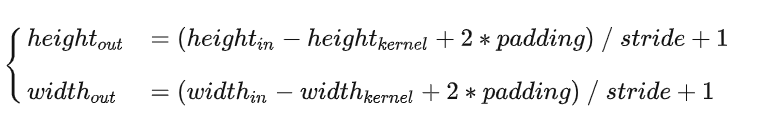

- input:
    - shape(10, 3, 224, 224) 
    - 10:batch_size, 3:RGD ,224: width, 224:high
- conv:(in_depth=3, out_depth=64, kernel_size=7, stride=2, padding=3)
- output:
    - width = (224-7+2*3)/2 + 1 = 112
    - high = (224-7+2*3)/2 +1 = 112
    - out_depth:64
    - batch_dize:10
    - shape:(10, 64, 112, 112)